In [4]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import bilby
from bilby.core.prior import Uniform, Cosine
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters
from gwpy.timeseries import TimeSeries

strain_H1 = TimeSeries.read('PE.gwf', channel='H1:FAKE_STRAIN')
strain_L1 = TimeSeries.read('PE.gwf', channel='L1:FAKE_STRAIN')
strain_V1 = TimeSeries.read('PE.gwf', channel='V1:FAKE_STRAIN')

print("Strain data read from GWF file")


H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")
V1 = bilby.gw.detector.get_empty_interferometer("V1")

H1.set_strain_data_from_gwpy_timeseries(strain_H1)
L1.set_strain_data_from_gwpy_timeseries(strain_L1)
V1.set_strain_data_from_gwpy_timeseries(strain_V1)

psd_H1 = strain_H1.psd(fftlength=4)
psd_L1 = strain_L1.psd(fftlength=4)
psd_V1 = strain_V1.psd(fftlength=4)

H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=psd_H1.frequencies.value, psd_array=psd_H1.value)
L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=psd_L1.frequencies.value, psd_array=psd_L1.value)
V1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=psd_V1.frequencies.value, psd_array=psd_V1.value)

print("Interferometers set up with PSDs")




Strain data read from GWF file
Interferometers set up with PSDs


In [5]:
from bilby.core.prior import PowerLaw
event_time = 1126259642.1679688

prior = bilby.core.prior.PriorDict()
prior['mass_1'] = Uniform(name='mass_1', minimum=20.0, maximum=50.0)
prior['mass_2'] = Uniform(name='mass_2', minimum=20.0, maximum=50.0)
prior['phase'] = 1.3
prior['geocent_time'] = Uniform(name="geocent_time", minimum=event_time-0.4, maximum=event_time+0.4)


prior['a_1'] = 0.0
prior['a_2'] = 0.0
prior['tilt_1'] = 0.0
prior['tilt_2'] = 0.0
prior['phi_12'] = 0.0
prior['phi_jl'] = 0.0


prior['dec'] = Cosine(name='dec')
prior['ra'] = Uniform(name='ra', minimum=0, maximum=2*np.pi, boundary='periodic')
prior['theta_jn'] = 0.4
prior['psi'] = 0.0
prior['luminosity_distance'] = PowerLaw(alpha=2, name="luminosity_distance",minimum=200, maximum=1500,unit="Mpc",latex_label="$d_L$")

interferometers = [H1, L1, V1]

waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',reference_frequency=100.,catch_waveform_errors=True,)

waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters,
    
)

likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers=interferometers,
    waveform_generator=waveform_generator,
    priors=prior,
    time_marginalization=True,
)

10:30 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [6]:
print("Running sampler...")
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=prior,
    sampler='dynesty',
    outdir='short5',
    label='pe5',
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    nlive=500,
    dlogz=0.1,
    clean=True,
)

print("Saving posterior samples...")
result.posterior.to_csv("posterior_pe5.csv", index=False)
print("Done.")


10:30 bilby INFO    : Running for label 'pe5', output will be saved to 'short5'
10:30 bilby INFO    : Using lal version 7.6.1
10:30 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.25.1;Id: 494fadf7ab3675a7708c6f21de0f588c68441850;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
10:30 bilby INFO    : Using lalsimulation version 6.1.0
10:30 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.25.1;Id: 494fadf7ab3675a7708c6f21de0f588c68441850;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed


Running sampler...


10:30 bilby INFO    : Analysis priors:
10:30 bilby INFO    : mass_1=Uniform(minimum=20.0, maximum=50.0, name='mass_1', latex_label='$m_1$', unit=None, boundary=None)
10:30 bilby INFO    : mass_2=Uniform(minimum=20.0, maximum=50.0, name='mass_2', latex_label='$m_2$', unit=None, boundary=None)
10:30 bilby INFO    : dec=Cosine(minimum=-1.5707963267948966, maximum=1.5707963267948966, name='dec', latex_label='$\\mathrm{DEC}$', unit=None, boundary=None)
10:30 bilby INFO    : ra=Uniform(minimum=0, maximum=6.283185307179586, name='ra', latex_label='$\\mathrm{RA}$', unit=None, boundary='periodic')
10:30 bilby INFO    : luminosity_distance=PowerLaw(alpha=2, minimum=200, maximum=1500, name='luminosity_distance', latex_label='$d_L$', unit='Mpc', boundary=None)
10:30 bilby INFO    : time_jitter=Uniform(minimum=-0.000244140625, maximum=0.000244140625, name='time_jitter', latex_label='$t_j$', unit=None, boundary='periodic')
10:30 bilby INFO    : phase=1.3
10:30 bilby INFO    : geocent_time=1126259619

1it [00:00, ?it/s]

10:40 bilby INFO    : Written checkpoint file short5/pe5_resume.pickle
/home/lucky/anaconda3/lib/python3.12/site-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/lucky/anaconda3/lib/python3.12/site-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
10:55 bilby INFO    : Written checkpoint file short5/pe5_resume.pickle
10:55 bilby WARNING : The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
10:55 bilby WARNING : Fai

18:47 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/2220 [00:00<?, ?it/s]

18:50 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/2220 [00:00<?, ?it/s]

18:56 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/2220 [00:00<?, ?it/s]

18:56 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/2220 [00:00<?, ?it/s]

18:59 bilby INFO    : Summary of results:
nsamples: 2220
ln_noise_evidence: -188256.656
ln_evidence: -187719.015 +/-  0.250
ln_bayes_factor: 537.641 +/-  0.250



Saving posterior samples...
Done.


mass_1 : median = 42.346, 90% C.I. = [42.185, 42.491]


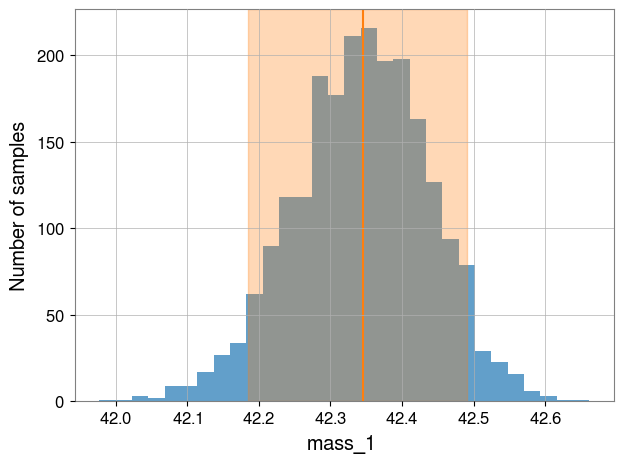

mass_2 : median = 22.453, 90% C.I. = [22.203, 22.715]


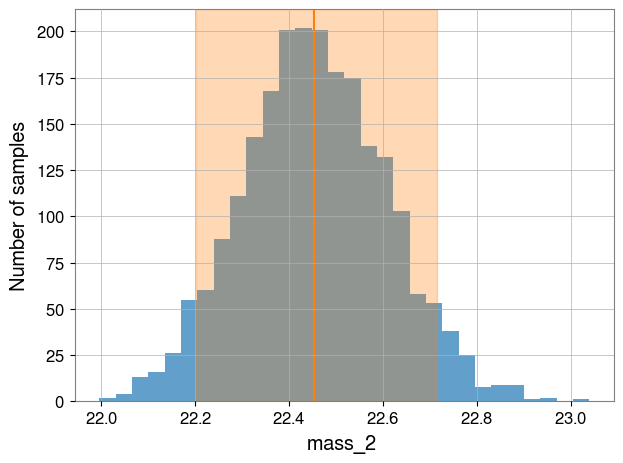

mass_ratio: median = 1.886, 90% C.I. = [1.860, 1.912]


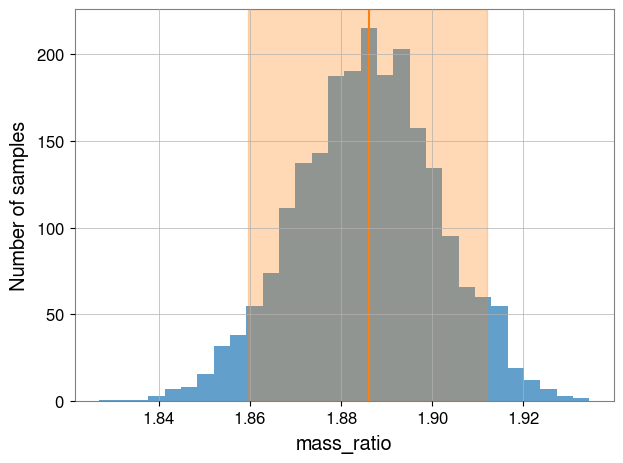

chirp_mass: median = 26.578, 90% C.I. = [26.446, 26.716]


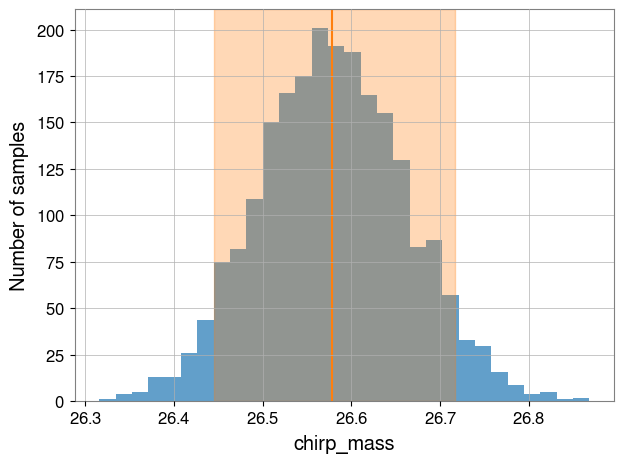

ra: median = 1.381, 90% C.I. = [1.359, 1.404]


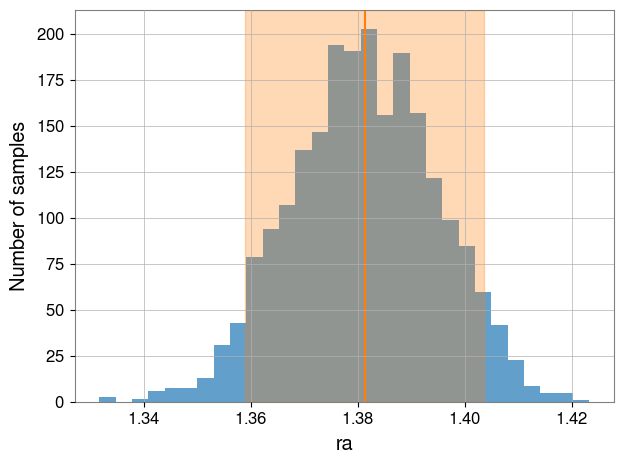

dec: median = -1.209, 90% C.I. = [-1.232, -1.184]


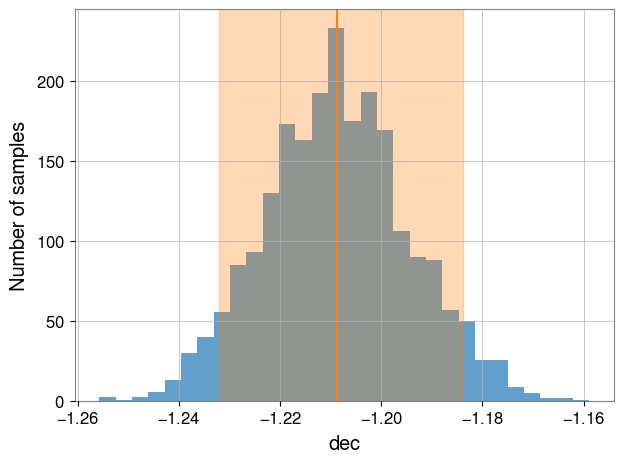

luminosity_distance: median = 959.137, 90% C.I. = [910.156, 1009.656]


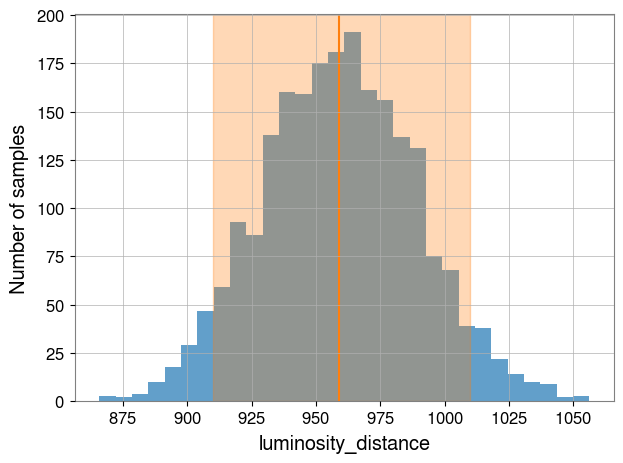

In [16]:
import numpy as np
import matplotlib.pyplot as plt

mass_1 = result.posterior["mass_1"].values
mass_2 = result.posterior["mass_2"].values

# Sort: mass_1 >= mass_2
mass_1_sorted = np.maximum(mass_1, mass_2)
mass_2_sorted = np.minimum(mass_1, mass_2)
mass_ratio_sorted = mass_1_sorted / mass_2_sorted

# function to plot a parameter's histogram with credible interval
def plot_posterior(param_values, param_name):
    median = np.quantile(param_values, 0.5)
    lower = np.quantile(param_values, 0.05)
    upper = np.quantile(param_values, 0.95)

    print(f"{param_name}: median = {median:.3f}, 90% C.I. = [{lower:.3f}, {upper:.3f}]")

    fig, ax = plt.subplots()
    ax.hist(param_values, bins=30, color='C0', alpha=0.7)
    ax.axvline(median, color='C1', label='Median')
    ax.axvspan(lower, upper, color='C1', alpha=0.3, label='90% C.I.')
    ax.set_xlabel(param_name)
    ax.set_ylabel("Number of samples")
    
    plt.tight_layout()
    
    # Save the figure as PNG
    filename = f"{param_name.strip().replace(' ', '_')}_posterior.png"
    fig.savefig(filename, dpi=300)

    plt.show()

plot_posterior(mass_1_sorted, "mass_1 ")
plot_posterior(mass_2_sorted, "mass_2 ")
plot_posterior(mass_ratio_sorted, "mass_ratio")

for param in ["chirp_mass", "ra", "dec", "luminosity_distance"]:
    plot_posterior(result.posterior[param].values, param)





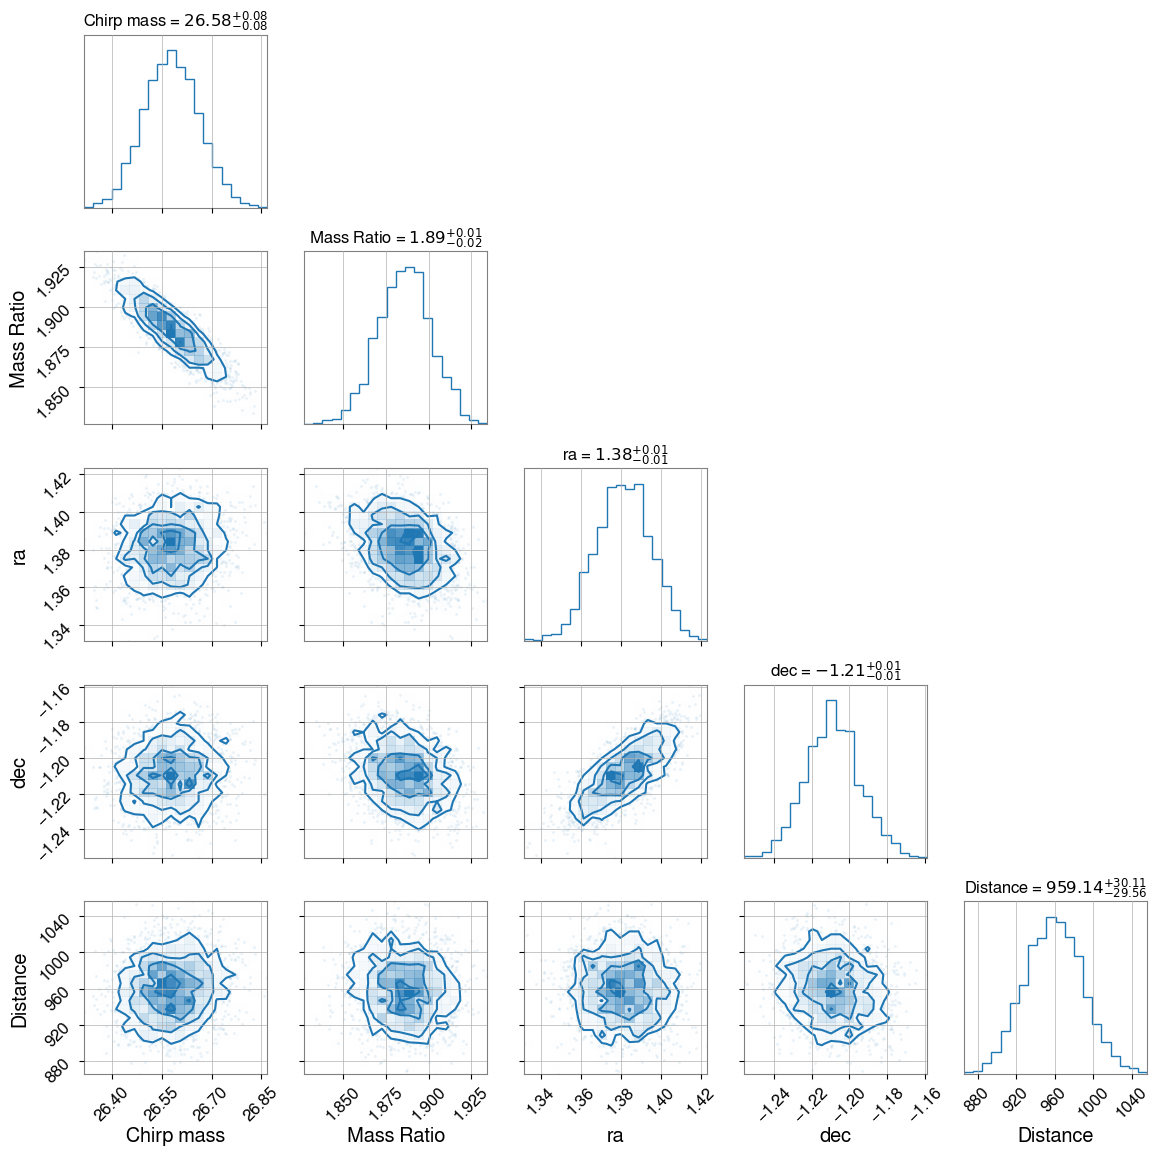

In [14]:
import corner

samples = np.vstack([
    result.posterior["chirp_mass"].values,
    mass_ratio_sorted,
    result.posterior["ra"].values,
    result.posterior["dec"].values,
    result.posterior["luminosity_distance"].values
]).T

parameter_names = ["Chirp mass", "Mass Ratio", "ra", "dec","Distance"]

fig = corner.corner(samples, labels=parameter_names, show_titles=True, title_kwargs={"fontsize": 12}, 
                    fill=True, color='C0', show_ticks=True, plot_datapoints=True, plot_density=True)
plt.tight_layout()
plt.show()